TODO
- land mask halo mask
- ice mask

In [1]:
# Working env variables
jupyterhub = False
smalltest = True

In [2]:
if jupyterhub:
    !pip install ..

In [3]:
import numpy as np
import cmocean
import xgcm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import ecco_v4_py as ecco
import xmitgcm.llcreader as llcreader

import dask.array as da
from dask.distributed import Client

import tqdm

import xarray as xr
import pandas as pd

import uuid

import zarr

In [4]:
import data_ingestion.get_raw_data as get_raw_data
import utils.native_gradient as ng
import plotting.llc_plotting as llc_plotting

import data_preprocessing.preproc_llc_core_data as preproc_llc_core_data
import utils.physical_calculations as physical_calculations

import data_preprocessing.weighted_coordinate_sampling as weighted_coordinate_sampling

import data_preprocessing.halo_mask as halo_mask

import data_preprocessing.spatial_patches as spatial_patches

import dataset_creation.metadata as metadata

import data_preprocessing.stats as stats



In [5]:
feature_channels = ["Eta", "Salt", "Theta", "U", "V", "W", "log_gradb"]
target_km_res = 150 #km
down_sample_res = 64 #pixels
halo_km = target_km_res/2

In [6]:
# set up dask distributed client
dask_client = Client()  # default: uses all local cores
dask_client

<Client: 'tcp://127.0.0.1:57898' processes=4 threads=16, memory=15.86 GiB>

In [7]:
# loop through all existing files

timestep_hours = 12                     # how many hours to load
sampling_step = 12                      # stride in timesteps
ts_per_hour = 144                       # model cadence: 25 s → 144 steps/hr
iter_step = sampling_step * ts_per_hour # iteration Δ between samples
face_range = range(13)

# NOTE MAX iteration : 1495008

# First valid wind/forcing record begins ~1180
start_record = 1180

# Compute iter numbers
start_iter = 10368 + start_record * ts_per_hour
end_iter = 1495008 #start_iter + timestep_hours * ts_per_hour
iter_range = np.arange(start_iter, end_iter, iter_step)

endpoint_url = 'https://mghp.osn.xsede.org'

In [8]:

# files = []
# for it in iter_range:
#     files.append(get_raw_data.get_remote_llc_data(endpoint_url, it, face_range))

In [9]:
it = iter_range[0]

co = get_raw_data.get_remote_gridfile(endpoint_url)
ds = get_raw_data.get_remote_llc_data(endpoint_url, it, face_range)

ds_merge, ds_grid = preproc_llc_core_data.process_llc4320(ds, co)


Opening 13 Kerchunk JSON files...
Parsing JSON metadata into Python dicts...
Creating lazy xarray datasets...
Computing delayed datasets...
Combining datasets by coordinates...
Dataset combined successfully.


In [10]:
if smalltest:
    ds_merge = ds_merge.isel(face = slice(0,1)) # grab the first face but keep face coords
    ds_grid = ds_grid.isel(face= slice(0,1))

# grid = xgcm.Grid(ds_grid, coords={'X':{'center':'XC'}}, periodic=False)
grid = xgcm.Grid(ds_grid, periodic=False)

In [11]:
# llc_plotting.plot_llc_faces_layout( ds_merge.Theta, vmin=-4, vmax=40 )

In [12]:
halo_land_mask = halo_mask.llc_halo_mask(
    mask=ds_grid.hFacC == 0,
    dxC=ds_grid["dxC"],
    dyC=ds_grid["dyC"],
    halo_km=halo_km
)

In [13]:
# first order approximation of freezing point
#tf = -0.056S - 0.008
freezing_point_tol = 0.5 #0.05
ice_mask = ds_merge.Theta <= ((-0.056*ds_merge.Salt) - 0.008 + freezing_point_tol)
# ice_mask = ds_merge.Theta <= -1.8

# ice_mask = ds_merge.Theta <= 0.0

In [ ]:
halo_ice_mask = halo_mask.llc_halo_mask(
    mask=ice_mask,
    dxC=ds_grid["dxC"],
    dyC=ds_grid["dyC"],
    halo_km=halo_km
)

In [ ]:
merged_mask = halo_ice_mask & halo_land_mask

C:\Users\jaket\PycharmProjects\llc4320-native-grid-preprocessing\.venv\Lib\site-packages\plotting\llc_plotting.py:145: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


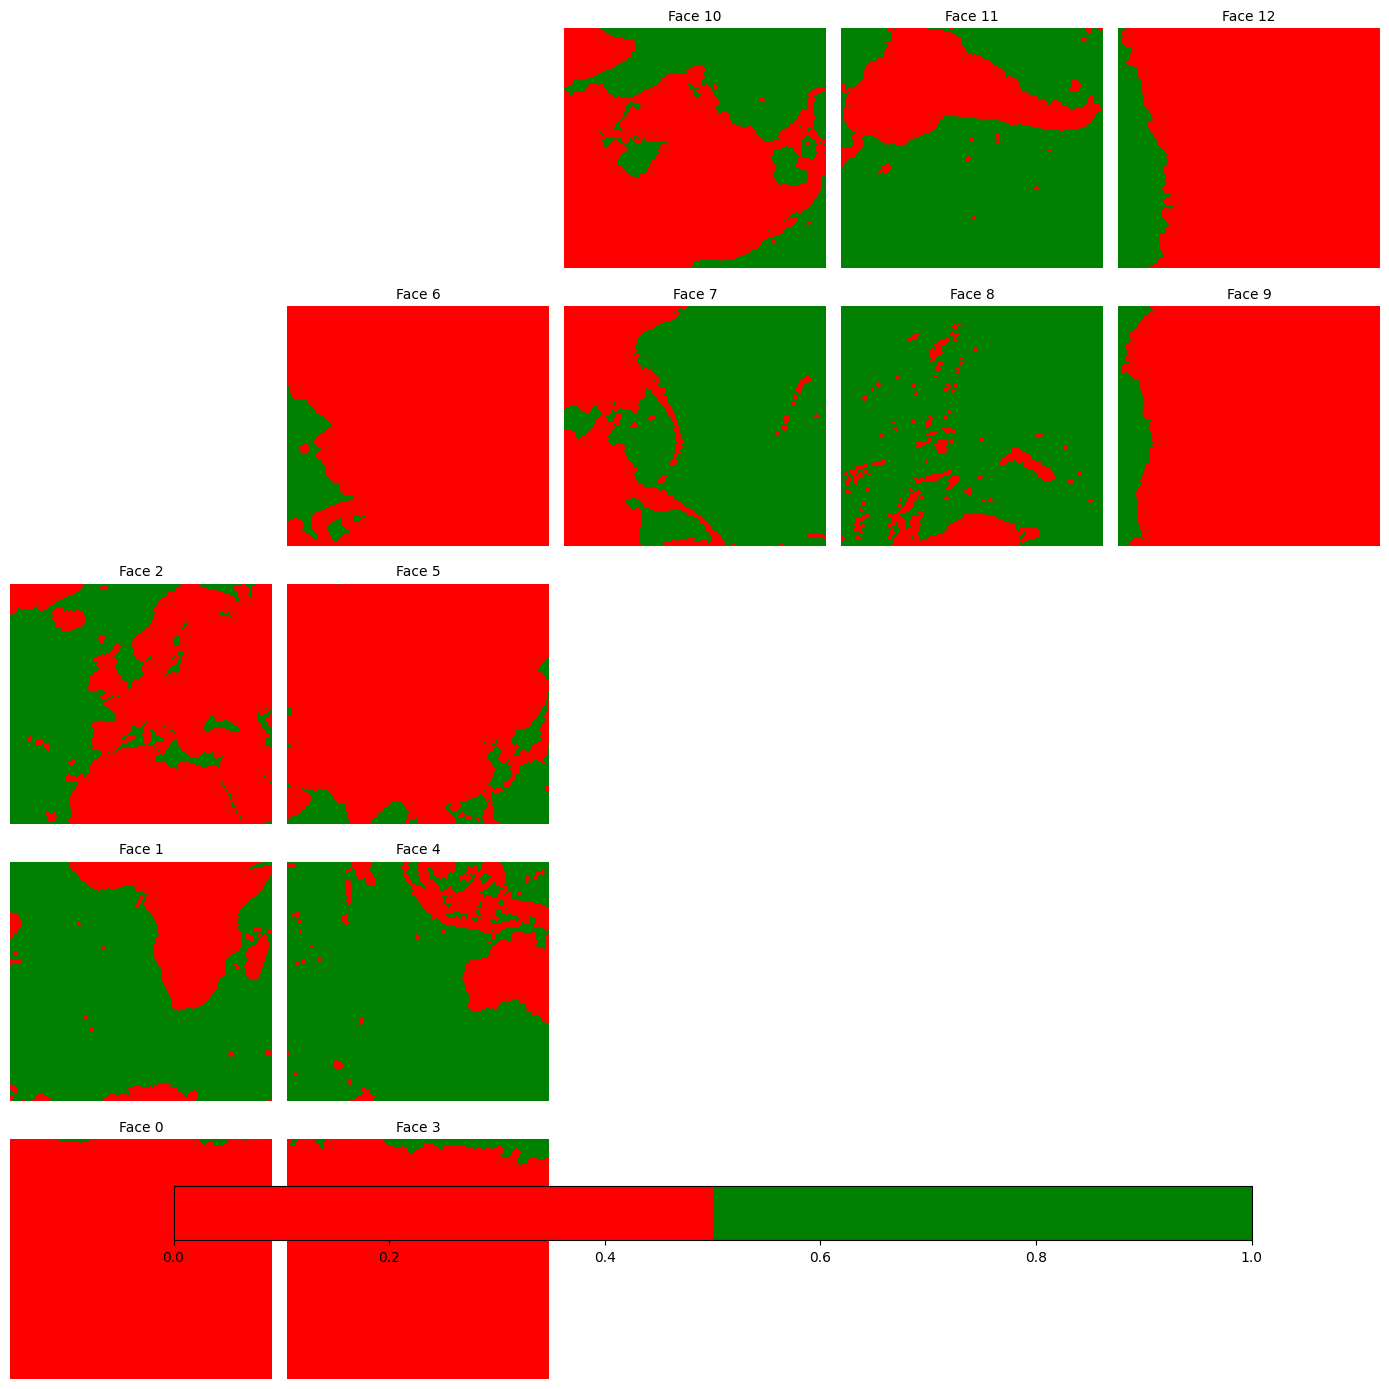

In [14]:
# cmap_bool = colors.ListedColormap(['red', 'green'])
# llc_plotting.plot_llc_faces_layout(xr.DataArray(merged_mask), color_map=cmap_bool, is_mask=True, vmin=0, vmax=1 )

In [8]:
# Meridional and Zonal Gradient of theta
ds_dx_hatx_G, ds_dy_haty_G = ng.calculate_native_gradient_tracer(ds_merge.Theta, ds_grid, grid=grid)

In [9]:
buoyancy = physical_calculations.buoyancy_of_field(ds_merge)

# gradient of b
zonal_grad_b, merid_grad_b = ng.calculate_native_gradient_tracer(buoyancy, ds_grid, grid=grid)

zonal_grad_b.persist()
merid_grad_b.persist()

gradb2 = physical_calculations.grad_squared(zonal_grad_b, merid_grad_b)
gradb2.persist()


log_gradb = da.log10(gradb2)
log_gradb.persist()

log_gradb_ds = log_gradb.to_dataset(name="log_gradb")
ds_merge = xr.merge([ds_merge, log_gradb_ds])

# Sample data points weighted toward high gradient values

## Option 1 : Sample from gradients directly on the grid

This is the best option I believe

slowish

In [10]:
# # sample on grid
SAMPLE_POINTS = 100 # todo what do we want here?

if smalltest:
    SAMPLE_POINTS = 50

bias_to_high_gradients = 0.5  # < 1 flattens, > 1 sharpens

indices = weighted_coordinate_sampling.weighted_sample_on_grid(SAMPLE_POINTS, bias_to_high_gradients, log_gradb, merged_mask)

# TODO display weights mask

C:\Users\jaket\PycharmProjects\llc4320-native-grid-preprocessing\.venv\Lib\site-packages\distributed\client.py:3370: UserWarning: Sending large graph of size 19.91 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


## Option 2 Sample from pdf and find matching values in the grid

In [11]:
# x = log_gradb.values  # loads data into memory
#
# samples = weighted_coordinate_sampling.sample_linearly_on_pdf(x, SAMPLE_POINTS, False)
# tolerance = 5e-7
# indices2 = weighted_coordinate_sampling.find_coords_first_parallel(x, samples, tol=tolerance, n_jobs=3) # this uses a lot of ram but is pretty fast

100%|██████████| 50/50 [00:09<00:00,  5.53it/s]


# Generate Spatial Patches from Our Indices

# Meta data :

id
location : lat lon corners and center
Actual : km size, resolution
gradb center point value


In [15]:
# Move non tracer values to tracer points
# only run this once or weird stuff happens
ds_merge["V"] = grid.interp(ds_merge["V"], 'Y', boundary='fill')
ds_merge["U"] = grid.interp(ds_merge["U"], 'X', boundary='fill')

In [92]:
# set up metadata
meta_data_filename = "metadata" # todo s3 location
meda_data_file_path = meta_data_filename + ".parquet"

metadata_cols = [
    "id",
    "dataset_index",
    "native_grid",
    "center_grid_face",
    "center_grid_j",
    "center_grid_i",
    "center_lat",
    "center_lon",
    "target_km_res",
    "real_km_w",
    "real_km_h",
    "pre_interp_res",
    "log_grad_b_2_center",

    "time_snapshot" # todo need info from model docs to get this - could store index for now
]

metadata_writer = metadata.MetadataWriter(meda_data_file_path, flush_every=10000)

In [94]:
# TODO s3 store and create a class

dataset_path = "dataset.zarr"
store = zarr.open_group(dataset_path, mode="a")

C, H, W = len(feature_channels), down_sample_res, down_sample_res

if "images" not in store:
    store.create_array(
        "images",
        shape=(0, C, H, W),
        chunks=(1, C, H, W),
        dtype="float32"
    )

In [95]:
def append_image(zstore, img): # todo batch? and make this a class
    zstore["images"].append(np.expand_dims(img, axis=0), axis=0)
    n = store["images"].shape[0]
    return n   # zarr index

In [96]:
patches = []
print()
# this is our main loop of data creation
# todo parallelize obviously
for index in tqdm.tqdm(indices):
    if index is not None:
        patch_metadata = dict.fromkeys(metadata_cols)
        patch_metadata["id"] = str(uuid.uuid4())
        patch_metadata["native_grid"] = "LLC4320" # todo all supported for now
        patch_metadata["center_grid_face"] = index[0]
        patch_metadata["center_grid_j"] = index[1]
        patch_metadata["center_grid_i"] = index[2]
        patch_metadata["target_km_res"] = target_km_res
        patch_metadata["center_lat"] = ds_merge.YC[index].values.item()
        patch_metadata["center_lon"] = ds_merge.XC[index].values.item()
        patch_metadata["log_grad_b_2_center"] = (ds_merge.log_gradb[index].values.item())

        patch = spatial_patches.get_lat_lon_extents_of_patch(index, ds_merge, target_km_res)

        if(patch is None):
            continue # todo we should log this somehow

        patches.append(patch)

        patch_metadata["real_km_w"] = patch["real_km_w"]
        patch_metadata["real_km_h"] = patch["real_km_h"]

        # # uncomment for dataset creation
        # patch_img = ds_merge.Theta.isel(
        #     face=patch["face"],
        #     j=slice(patch["j_start"], patch["j_end"] + 1),
        #     i=slice(patch["i_start"], patch["i_end"] + 1)
        # )
        # patch_metadata["pre_interp_res"] = patch_img.shape
        # img_patch = spatial_patches.create_image_patch(feature_channels, patch)
        # data_sample = spatial_patches.downsample_image(img_patch)
        #
        # # add data to zarr
        # idx = append_image(store, data_sample)
        # patch_metadata["dataset_index"] = idx


        # add metadata
        metadata_writer.add(patch_metadata)

metadata_writer.close()


  2%|▏         | 1/50 [00:10<08:33, 10.49s/it]

torch.Size([1, 7, 64, 64])
torch.Size([7, 64, 64])


  4%|▍         | 2/50 [00:13<05:04,  6.34s/it]

HIT FACE
ENDING j INDICES IS GREATER THAN END OF FACE AND THEREFORE OFF THE FACE OR DATA
HIT FACE


  6%|▌         | 3/50 [00:17<04:07,  5.26s/it]

STARTING i INDICES IS LESS THAN ZERO AND THEREFORE OFF THE FACE OR DATA


  8%|▊         | 4/50 [00:27<05:20,  6.97s/it]

torch.Size([1, 7, 64, 64])
torch.Size([7, 64, 64])


 10%|█         | 5/50 [00:41<07:03,  9.41s/it]

torch.Size([1, 7, 64, 64])
torch.Size([7, 64, 64])


 12%|█▏        | 6/50 [00:52<07:20, 10.02s/it]

torch.Size([1, 7, 64, 64])
torch.Size([7, 64, 64])


 14%|█▍        | 7/50 [01:02<07:13, 10.07s/it]

torch.Size([1, 7, 64, 64])
torch.Size([7, 64, 64])


 16%|█▌        | 8/50 [01:13<07:07, 10.18s/it]

torch.Size([1, 7, 64, 64])
torch.Size([7, 64, 64])


 18%|█▊        | 9/50 [01:24<07:17, 10.66s/it]

torch.Size([1, 7, 64, 64])
torch.Size([7, 64, 64])


 20%|██        | 10/50 [01:36<07:20, 11.01s/it]

torch.Size([1, 7, 64, 64])
torch.Size([7, 64, 64])


 22%|██▏       | 11/50 [01:51<07:52, 12.12s/it]

torch.Size([1, 7, 64, 64])
torch.Size([7, 64, 64])


 24%|██▍       | 12/50 [02:05<08:05, 12.79s/it]

torch.Size([1, 7, 64, 64])
torch.Size([7, 64, 64])


 26%|██▌       | 13/50 [02:17<07:49, 12.69s/it]

torch.Size([1, 7, 64, 64])
torch.Size([7, 64, 64])


 28%|██▊       | 14/50 [02:28<07:17, 12.16s/it]

torch.Size([1, 7, 64, 64])
torch.Size([7, 64, 64])


 30%|███       | 15/50 [03:04<11:17, 19.35s/it]

torch.Size([1, 7, 64, 64])
torch.Size([7, 64, 64])


 32%|███▏      | 16/50 [03:18<09:59, 17.62s/it]

torch.Size([1, 7, 64, 64])
torch.Size([7, 64, 64])


 34%|███▍      | 17/50 [03:27<08:20, 15.17s/it]

torch.Size([1, 7, 64, 64])
torch.Size([7, 64, 64])


 36%|███▌      | 18/50 [03:36<07:04, 13.27s/it]

torch.Size([1, 7, 64, 64])
torch.Size([7, 64, 64])


 38%|███▊      | 19/50 [03:49<06:50, 13.24s/it]

torch.Size([1, 7, 64, 64])
torch.Size([7, 64, 64])


 40%|████      | 20/50 [04:02<06:30, 13.00s/it]

torch.Size([1, 7, 64, 64])
torch.Size([7, 64, 64])


 42%|████▏     | 21/50 [04:13<05:57, 12.33s/it]

torch.Size([1, 7, 64, 64])
torch.Size([7, 64, 64])


 44%|████▍     | 22/50 [04:22<05:23, 11.57s/it]

torch.Size([1, 7, 64, 64])
torch.Size([7, 64, 64])


 46%|████▌     | 23/50 [04:33<05:05, 11.31s/it]

torch.Size([1, 7, 64, 64])
torch.Size([7, 64, 64])


 48%|████▊     | 24/50 [04:47<05:14, 12.11s/it]

torch.Size([1, 7, 64, 64])
torch.Size([7, 64, 64])


 50%|█████     | 25/50 [04:59<05:03, 12.15s/it]

torch.Size([1, 7, 64, 64])
torch.Size([7, 64, 64])


 52%|█████▏    | 26/50 [05:13<05:03, 12.63s/it]

torch.Size([1, 7, 64, 64])
torch.Size([7, 64, 64])


 54%|█████▍    | 27/50 [05:17<03:51, 10.07s/it]

HIT FACE
ENDING j INDICES IS GREATER THAN END OF FACE AND THEREFORE OFF THE FACE OR DATA


 56%|█████▌    | 28/50 [05:32<04:13, 11.54s/it]

torch.Size([1, 7, 64, 64])
torch.Size([7, 64, 64])


 58%|█████▊    | 29/50 [05:45<04:08, 11.85s/it]

torch.Size([1, 7, 64, 64])
torch.Size([7, 64, 64])


 60%|██████    | 30/50 [05:57<03:59, 11.97s/it]

torch.Size([1, 7, 64, 64])
torch.Size([7, 64, 64])


 62%|██████▏   | 31/50 [06:07<03:35, 11.34s/it]

torch.Size([1, 7, 64, 64])
torch.Size([7, 64, 64])


 64%|██████▍   | 32/50 [06:20<03:32, 11.81s/it]

torch.Size([1, 7, 64, 64])
torch.Size([7, 64, 64])
HIT FACE


 66%|██████▌   | 33/50 [06:25<02:47,  9.84s/it]

STARTING i INDICES IS LESS THAN ZERO AND THEREFORE OFF THE FACE OR DATA


 68%|██████▊   | 34/50 [06:36<02:43, 10.20s/it]

torch.Size([1, 7, 64, 64])
torch.Size([7, 64, 64])


 70%|███████   | 35/50 [06:47<02:36, 10.40s/it]

torch.Size([1, 7, 64, 64])
torch.Size([7, 64, 64])


 72%|███████▏  | 36/50 [06:57<02:23, 10.27s/it]

torch.Size([1, 7, 64, 64])
torch.Size([7, 64, 64])


 74%|███████▍  | 37/50 [07:10<02:23, 11.02s/it]

torch.Size([1, 7, 64, 64])
torch.Size([7, 64, 64])


 76%|███████▌  | 38/50 [07:20<02:11, 10.92s/it]

torch.Size([1, 7, 64, 64])
torch.Size([7, 64, 64])


 78%|███████▊  | 39/50 [07:31<02:00, 10.92s/it]

torch.Size([1, 7, 64, 64])
torch.Size([7, 64, 64])


 80%|████████  | 40/50 [07:43<01:50, 11.06s/it]

torch.Size([1, 7, 64, 64])
torch.Size([7, 64, 64])


 82%|████████▏ | 41/50 [07:54<01:39, 11.07s/it]

torch.Size([1, 7, 64, 64])
torch.Size([7, 64, 64])


 84%|████████▍ | 42/50 [08:07<01:33, 11.66s/it]

torch.Size([1, 7, 64, 64])
torch.Size([7, 64, 64])


 86%|████████▌ | 43/50 [08:18<01:20, 11.51s/it]

torch.Size([1, 7, 64, 64])
torch.Size([7, 64, 64])


 88%|████████▊ | 44/50 [08:29<01:08, 11.35s/it]

torch.Size([1, 7, 64, 64])
torch.Size([7, 64, 64])


 90%|█████████ | 45/50 [08:41<00:58, 11.64s/it]

torch.Size([1, 7, 64, 64])
torch.Size([7, 64, 64])


 92%|█████████▏| 46/50 [08:52<00:45, 11.29s/it]

torch.Size([1, 7, 64, 64])
torch.Size([7, 64, 64])


 94%|█████████▍| 47/50 [09:05<00:35, 11.83s/it]

torch.Size([1, 7, 64, 64])
torch.Size([7, 64, 64])


 96%|█████████▌| 48/50 [09:17<00:23, 11.90s/it]

torch.Size([1, 7, 64, 64])
torch.Size([7, 64, 64])


 98%|█████████▊| 49/50 [09:27<00:11, 11.37s/it]

torch.Size([1, 7, 64, 64])
torch.Size([7, 64, 64])


100%|██████████| 50/50 [09:41<00:00, 11.64s/it]

torch.Size([1, 7, 64, 64])
torch.Size([7, 64, 64])


In [121]:
meta_df = pd.read_parquet("metadata.parquet")

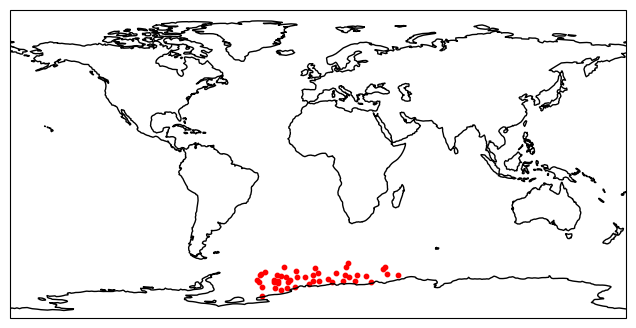

In [120]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

lats, lons = meta_df["center_lat"], meta_df["center_lon"]

fig = plt.figure(figsize=(8, 4))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.coastlines()
ax.set_global()
ax.scatter(
    lons,
    lats,
    s=10,
    color="red",
    transform=ccrs.PlateCarree()
)

plt.show()

In [17]:
# # polar point
# latlon_dict = get_lat_lon_extents_of_patch((6, 2159, 2159), log_gradb, ds_merge, 150)
#
# #print(latlon_dict["lat_min"], latlon_dict["lat_max"], latlon_dict["lon_min"], latlon_dict["lon_max"])

In [18]:
# # worst possible point for dx dy ratio 3 0 623
# latlon_dict = get_lat_lon_extents_of_patch((3, 700, 1023), log_gradb, ds_merge, 150)

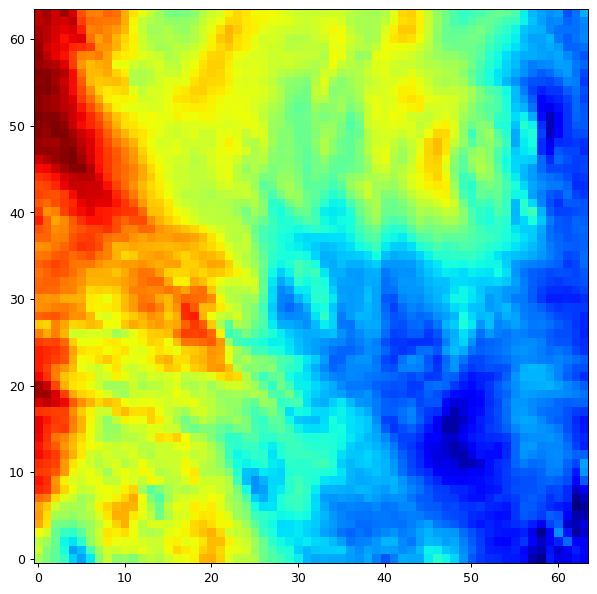

In [104]:
plt.figure(figsize=(8,8), dpi= 90)
plt.imshow(store["images"][0][4],origin='lower',cmap='jet')

(151, 149)


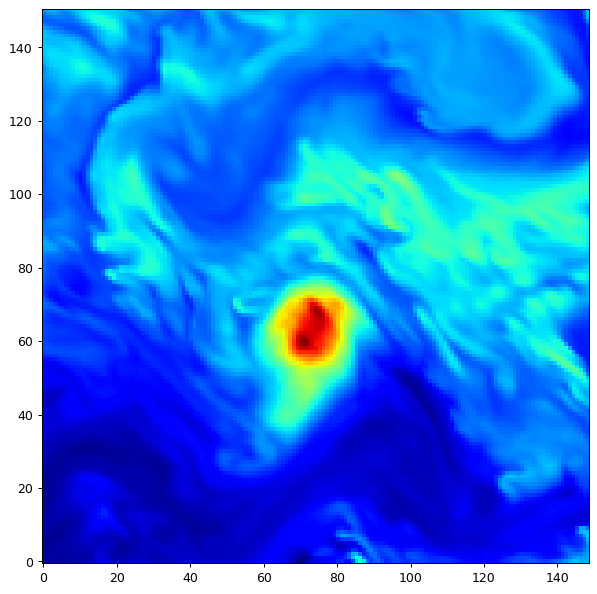

In [37]:

# print(latlon_dict["j_end"]-latlon_dict["j_start"])
# print(latlon_dict["i_end"]-latlon_dict["i_start"])
#
# print(latlon_dict["i_start"], latlon_dict["j_start"], latlon_dict["face"])
#
# print(slice(latlon_dict["j_start"], latlon_dict["j_end"] + 1))
i = 0
for patch in patches:
    if i >= 1:
        break
    if patch is not None:
        patch_img = ds_merge.Theta.isel(
            face=patch["face"],
            j=slice(patch["j_start"], patch["j_end"] + 1),
            i=slice(patch["i_start"], patch["i_end"] + 1)
        )

        print(patch_img.shape)

        plt.figure(figsize=(8,8), dpi= 90)
        plt.imshow(patch_img,origin='lower',cmap='jet')
    i+=1

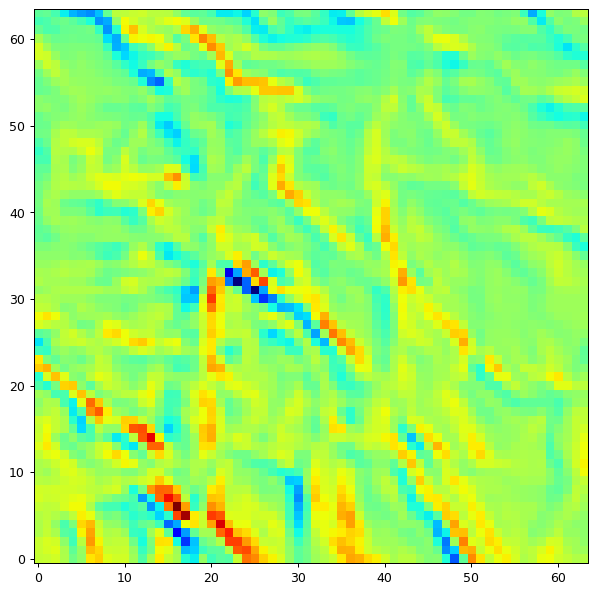

In [24]:
plt.figure(figsize=(8,8), dpi= 90)
plt.imshow(data_sample[5],origin='lower',cmap='jet')

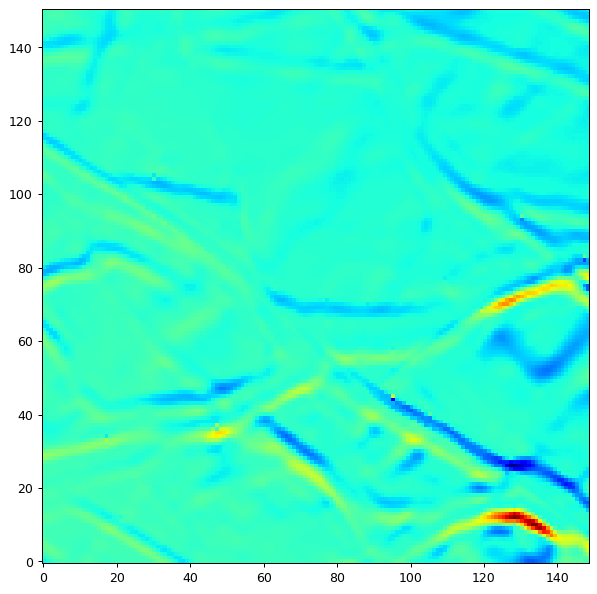

In [25]:
#COMPARE TO ORIGINAL

patch = patches[0]
patch_img = ds_merge["W"].isel(
            face=patch["face"],
            j=slice(patch["j_start"], patch["j_end"] + 1),
            i=slice(patch["i_start"], patch["i_end"] + 1)
        )
plt.figure(figsize=(8,8), dpi= 90)
plt.imshow(patch_img,origin='lower',cmap='jet')

# Using zarr build a full dataset


In [401]:
# print(latlon_dict["lat_min"], latlon_dict["lat_max"], latlon_dict["lon_min"], latlon_dict["lon_max"])

-60.253986 -59.814144 95.114586 95.989586


In [373]:
# from ecco_v4_py import resample_to_latlon
# new_grid_delta_lat = 0.05# 0.05
# new_grid_delta_lon = 0.05#0.05
#
# center_lat = (latlon_dict["lat_min"] + latlon_dict["lat_max"]) / 2
#
# km_per_deg_lat = 111.32
# km_per_deg_lon = 111.32 * np.cos(np.deg2rad(center_lat))
#
# # desired patch half-width in km
# km_res = 0.1 # todo this is not named well
#
# # convert km to degrees
# dlat = km_res / km_per_deg_lat
# dlon = km_res / km_per_deg_lon
#
# print(dlat, dlon)
#
# theta_patch_latlon = resample_to_latlon(
#     ds_merge.XC,
#     ds_merge.YC,
#     ds_merge.Theta,
#     latlon_dict["lat_min"], latlon_dict["lat_max"],
#     dlat,
#     latlon_dict["lon_min"], latlon_dict["lon_max"],
#     dlon,
#     mapping_method='nearest_neighbor'
# )
#
# # theta_patch_latlon = resample_to_latlon(
# #     ds_merge.XC,
# #     ds_merge.YC,
# #     ds_merge.Theta,
# #     lat_min, lat_max,
# #     new_grid_delta_lat,
# #     lon_min, lon_max,
# #     new_grid_delta_lon,
# #     mapping_method='nearest_neighbor'
# # )


0.000898311174991017 0.0017983449


In [402]:
new_grid_min_lat = -90
new_grid_max_lat = 90

new_grid_min_lon = -180
new_grid_max_lon = 180

full_interp = resample_to_latlon(
    ds_merge.XC,
    ds_merge.YC,
    ds_merge.Theta,
    new_grid_min_lat, new_grid_max_lat,
    1,
    new_grid_min_lon, new_grid_max_lon,
    1,
    mapping_method='nearest_neighbor'
)



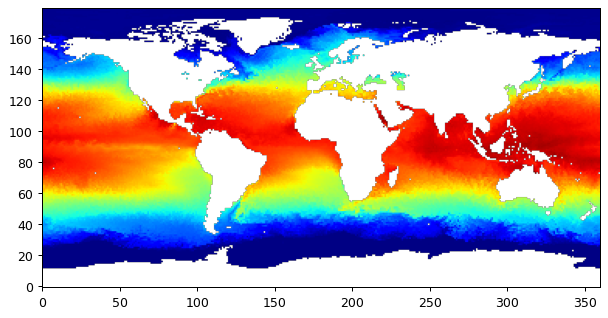

In [403]:
new_grid_lon_centers, new_grid_lat_centers,\
new_grid_lon_edges, new_grid_lat_edges,\
field = full_interp

plt.figure(figsize=(8,8), dpi= 90)
plt.imshow(field,origin='lower',cmap='jet')

In [375]:
new_grid_lon_centers, new_grid_lat_centers,\
new_grid_lon_edges, new_grid_lat_edges,\
field = theta_patch_latlon

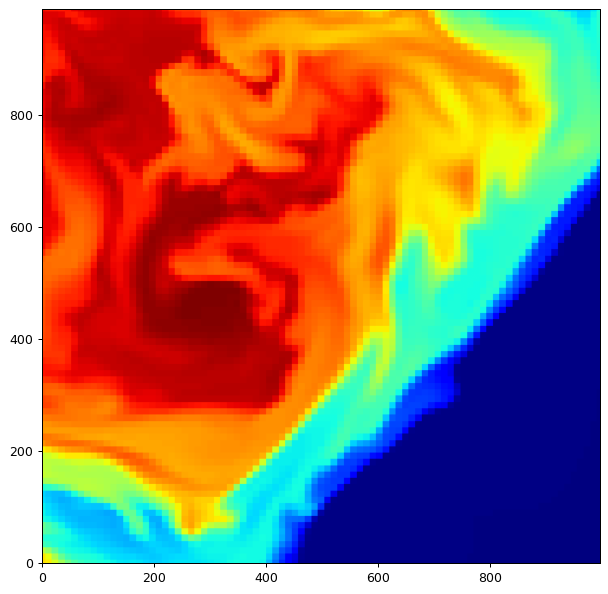

In [376]:
plt.figure(figsize=(8,8), dpi= 90)
plt.imshow(field,origin='lower',cmap='jet')

(<Figure size 640x480 with 2 Axes>,
 <GeoAxes: >,
 array([[-179.975, -179.925, -179.875, ...,  179.875,  179.925,  179.975],
        [-179.975, -179.925, -179.875, ...,  179.875,  179.925,  179.975],
        [-179.975, -179.925, -179.875, ...,  179.875,  179.925,  179.975],
        ...,
        [-179.975, -179.925, -179.875, ...,  179.875,  179.925,  179.975],
        [-179.975, -179.925, -179.875, ...,  179.875,  179.925,  179.975],
        [-179.975, -179.925, -179.875, ...,  179.875,  179.925,  179.975]],
       shape=(3600, 7200)),
 array([[-89.975, -89.975, -89.975, ..., -89.975, -89.975, -89.975],
        [-89.925, -89.925, -89.925, ..., -89.925, -89.925, -89.925],
        [-89.875, -89.875, -89.875, ..., -89.875, -89.875, -89.875],
        ...,
        [ 89.875,  89.875,  89.875, ...,  89.875,  89.875,  89.875],
        [ 89.925,  89.925,  89.925, ...,  89.925,  89.925,  89.925],
        [ 89.975,  89.975,  89.975, ...,  89.975,  89.975,  89.975]],
       shape=(3600, 7200)),
 m

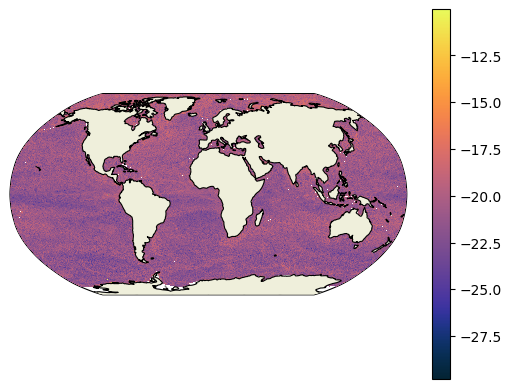

In [103]:
ecco.plot_proj_to_latlon_grid(ds_merge.XC,
                              ds_merge.YC,
                              log_gradb,
                              cmap=cmocean.cm.thermal,
                              plot_type = 'pcolormesh',
                              dx=0.05,
                              dy=0.05,
                              projection_type = 'robin',
                              less_output = True,
                              show_colorbar=True,
                              )

In [254]:
dx_row = ds_merge.dxC.sel(face=face).isel(j=100).values
len(dx_row)

4320

In [14]:
gradb2

<xarray.DataArray (face: 13, j: 4320, i: 4320)> Size: 2GB
dask.array<add, shape=(13, 4320, 4320), dtype=float64, chunksize=(1, 360, 360), chunktype=numpy.ndarray>
Coordinates:
  * face     (face) float64 104B 0.0 1.0 2.0 3.0 4.0 ... 8.0 9.0 10.0 11.0 12.0
  * j        (j) float64 35kB 0.0 1.0 2.0 3.0 ... 4.317e+03 4.318e+03 4.319e+03
  * i        (i) float64 35kB 0.0 1.0 2.0 3.0 ... 4.317e+03 4.318e+03 4.319e+03
    k        float64 8B 0.0
    k_l      float64 8B 0.0
    niter    float64 8B dask.array<chunksize=(), meta=np.ndarray>
    time     datetime64[ns] 8B 2011-11-01T04:00:00

In [24]:
hist

dask.array<sum-aggregate, shape=(100,), dtype=int64, chunksize=(100,), chunktype=numpy.ndarray>

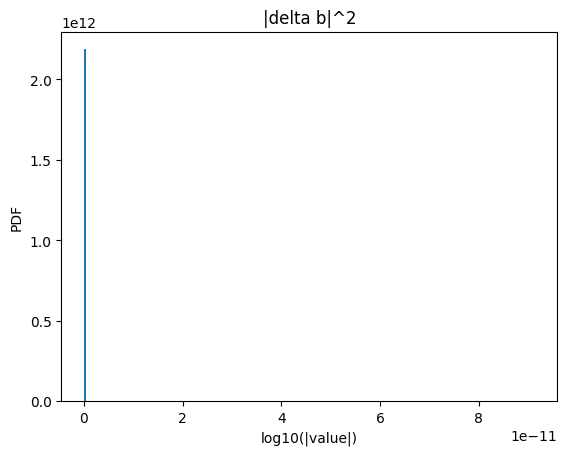

In [12]:
# llc_plotting.plot_pdf_dask(gradb2, "|delta b|^2", bins=100)

In [13]:
# 3 mins
vmin = gradb2.min().compute()

vmax = gradb2.max().compute()

min: <xarray.DataArray ()> Size: 8B
array(1.62128475e-30)
Coordinates:
    k        float64 8B 0.0
    k_l      float64 8B 0.0
    niter    float64 8B 1.803e+05
    time     datetime64[ns] 8B 2011-11-01T04:00:00 max: <xarray.DataArray ()> Size: 8B
array(9.13539113e-11)
Coordinates:
    k        float64 8B 0.0
    k_l      float64 8B 0.0
    niter    float64 8B 1.803e+05
    time     datetime64[ns] 8B 2011-11-01T04:00:00


In [16]:
print("min:", vmin)
print("max:", vmax)

min: <xarray.DataArray ()> Size: 8B
array(1.62128475e-30)
Coordinates:
    k        float64 8B 0.0
    k_l      float64 8B 0.0
    niter    float64 8B 1.803e+05
    time     datetime64[ns] 8B 2011-11-01T04:00:00
max: <xarray.DataArray ()> Size: 8B
array(9.13539113e-11)
Coordinates:
    k        float64 8B 0.0
    k_l      float64 8B 0.0
    niter    float64 8B 1.803e+05
    time     datetime64[ns] 8B 2011-11-01T04:00:00


In [ ]:
# sample based on pdf

# da: dask-backed xarray with dims (face, i, j)
data = gradb2.data  # dask array

# Flatten data lazily
flat = data.reshape(-1)  # still lazy

In [ ]:
pdf, bin_edges = da.histogram(flat, bins=200, range=[flat.min().compute(), flat.max().compute()])
bin_widths = np.diff(bin_edges)
prob_mass = pdf / pdf.sum()  # probabilities for each bin

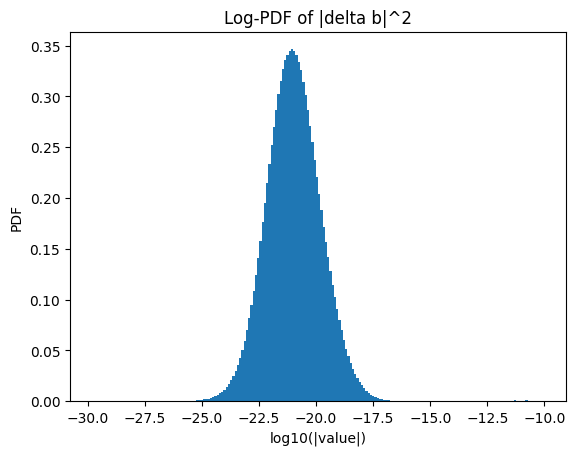

In [14]:
llc_plotting.plot_log_pdf(gradb2, "Log-PDF of |delta b|^2")

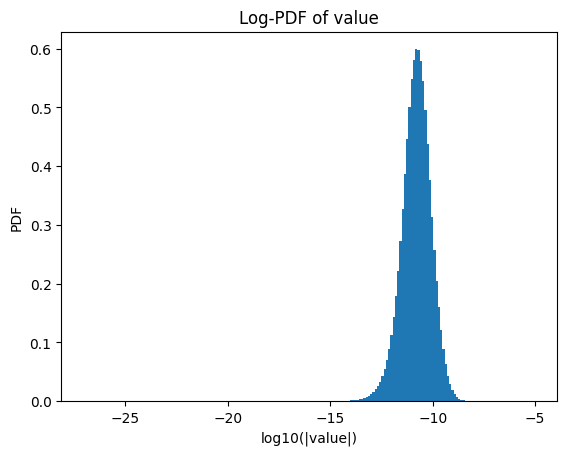

In [12]:
# log pdf of zonal grad b
llc_plotting.plot_log_pdf(zonal_grad_b, "Log-PDF of zonal buoyancy gradient")

In [12]:
llc_plotting.plot_log_faces_layout(gradb2, color_map = cmocean.cm.thermal, vmin=None, vmax=None)

2025-11-21 13:18:13,255 - distributed.nanny - WARNING - Restarting worker
2025-11-21 13:20:46,988 - distributed.nanny - WARNING - Restarting worker
2025-11-21 13:23:17,083 - distributed.nanny - WARNING - Restarting worker
2025-11-21 13:25:44,951 - distributed.nanny - WARNING - Restarting worker


KilledWorker: Attempted to run task 'finalize-hlgfinalizecompute-a526100ca021464a9ad840235476f362' on 4 different workers, but all those workers died while running it. The last worker that attempt to run the task was tcp://127.0.0.1:54490. Inspecting worker logs is often a good next step to diagnose what went wrong. For more information see https://distributed.dask.org/en/stable/killed.html.

-23.71681260294055 -18.14391581038101


(<Figure size 640x480 with 2 Axes>,
 <GeoAxes: >,
 array([[-179.875, -179.625, -179.375, ...,  179.375,  179.625,  179.875],
        [-179.875, -179.625, -179.375, ...,  179.375,  179.625,  179.875],
        [-179.875, -179.625, -179.375, ...,  179.375,  179.625,  179.875],
        ...,
        [-179.875, -179.625, -179.375, ...,  179.375,  179.625,  179.875],
        [-179.875, -179.625, -179.375, ...,  179.375,  179.625,  179.875],
        [-179.875, -179.625, -179.375, ...,  179.375,  179.625,  179.875]],
       shape=(720, 1440)),
 array([[-89.875, -89.875, -89.875, ..., -89.875, -89.875, -89.875],
        [-89.625, -89.625, -89.625, ..., -89.625, -89.625, -89.625],
        [-89.375, -89.375, -89.375, ..., -89.375, -89.375, -89.375],
        ...,
        [ 89.375,  89.375,  89.375, ...,  89.375,  89.375,  89.375],
        [ 89.625,  89.625,  89.625, ...,  89.625,  89.625,  89.625],
        [ 89.875,  89.875,  89.875, ...,  89.875,  89.875,  89.875]],
       shape=(720, 1440)),
 mas

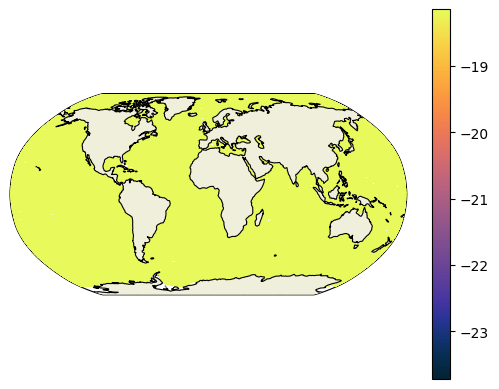

In [12]:
vals = np.abs(gradb2.values.ravel())
vals = vals[(vals > 0) & ~np.isnan(vals)]
logvals = np.log10(vals)

# find vmin and max for plot
vmin = np.quantile(logvals, 0.01)
vmax = np.quantile(logvals, 0.99)

print(vmin, vmax)

# create the log values xarray for plotting
vals = np.abs(gradb2)
vals = vals.where(vals > 0)

logvals_xarray = np.log10(vals)

(<Figure size 640x480 with 2 Axes>,
 <GeoAxes: >,
 array([[-179.975, -179.925, -179.875, ...,  179.875,  179.925,  179.975],
        [-179.975, -179.925, -179.875, ...,  179.875,  179.925,  179.975],
        [-179.975, -179.925, -179.875, ...,  179.875,  179.925,  179.975],
        ...,
        [-179.975, -179.925, -179.875, ...,  179.875,  179.925,  179.975],
        [-179.975, -179.925, -179.875, ...,  179.875,  179.925,  179.975],
        [-179.975, -179.925, -179.875, ...,  179.875,  179.925,  179.975]],
       shape=(3600, 7200)),
 array([[-89.975, -89.975, -89.975, ..., -89.975, -89.975, -89.975],
        [-89.925, -89.925, -89.925, ..., -89.925, -89.925, -89.925],
        [-89.875, -89.875, -89.875, ..., -89.875, -89.875, -89.875],
        ...,
        [ 89.875,  89.875,  89.875, ...,  89.875,  89.875,  89.875],
        [ 89.925,  89.925,  89.925, ...,  89.925,  89.925,  89.925],
        [ 89.975,  89.975,  89.975, ...,  89.975,  89.975,  89.975]],
       shape=(3600, 7200)),
 m

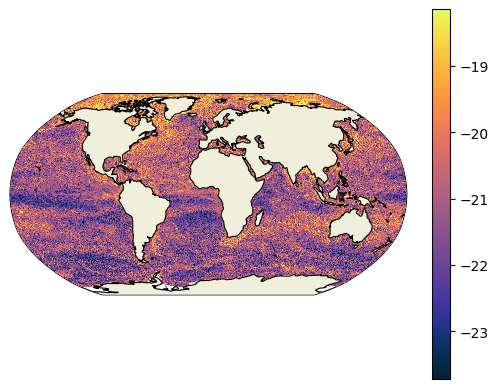

In [16]:
ecco.plot_proj_to_latlon_grid(ds_merge.XC,
                              ds_merge.YC,
                              logvals_xarray,
                              cmap=cmocean.cm.thermal,
                              plot_type = 'pcolormesh',
                              dx=0.05,
                              dy=0.05,
                              projection_type = 'robin',
                              less_output = True,
                              show_colorbar=True,
                              cmin=vmin, cmax=vmax)

In [17]:
llc_plotting.plot_log_faces_layout(zonal_grad_b, color_map = cmocean.cm.thermal, vmin=None, vmax=None)

Task exception was never retrieved
future: <Task finished name='Task-337460' coro=<Client._gather.<locals>.wait() done, defined at C:\Users\Jake Tallman\PycharmProjects\dbof-in-native-grid\.venv\Lib\site-packages\distributed\client.py:2384> exception=AllExit()>
Traceback (most recent call last):
  File "C:\Users\Jake Tallman\PycharmProjects\dbof-in-native-grid\.venv\Lib\site-packages\distributed\client.py", line 2393, in wait
    raise AllExit()
distributed.client.AllExit


KeyboardInterrupt: 

C:\Users\Jake Tallman\PycharmProjects\dbof-in-native-grid\src\plotting\llc_plotting.py:107: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


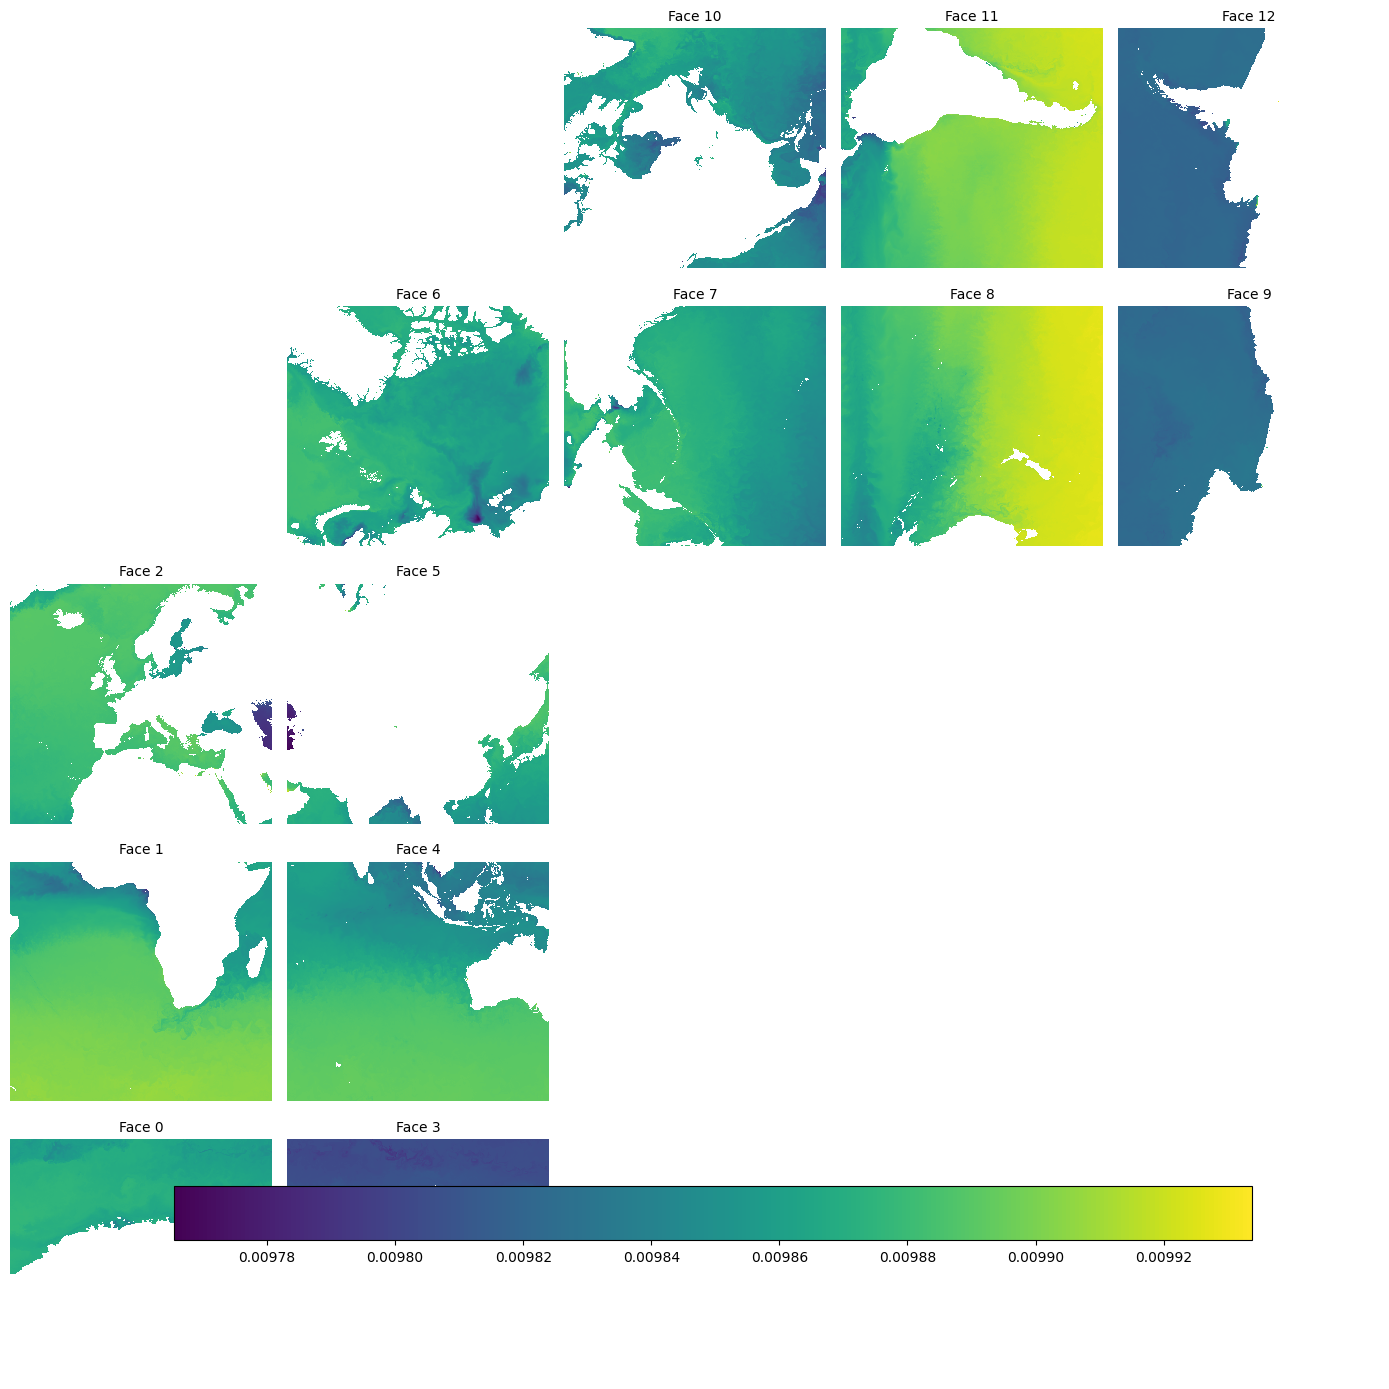

In [10]:
# plot of buoyancy
llc_plotting.plot_llc_faces_layout(buoyancy, "viridis")

Show Gradient Theta!

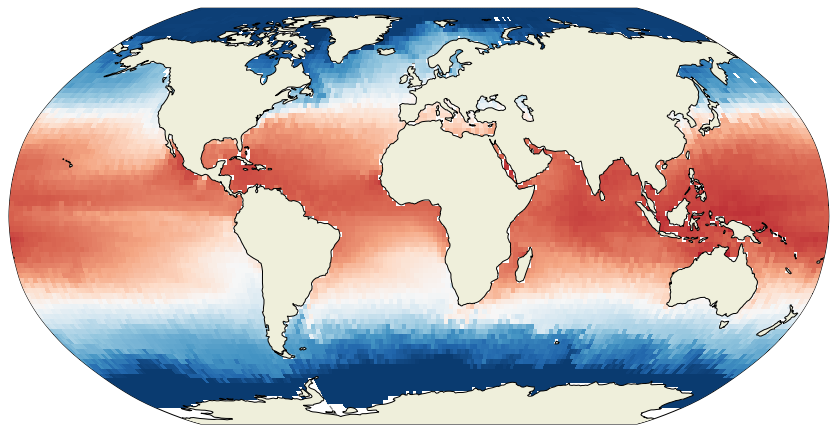

In [47]:
plt.figure(figsize=(12,6), dpi= 90)

tmp_plt = ds_merge.Theta

ecco.plot_proj_to_latlon_grid(ds_merge.XC, \
                              ds_merge.YC, \
                              tmp_plt, \
                              plot_type = 'pcolormesh', \
                              dx=2,\
                              dy=2, \
                              projection_type = 'robin',\
                              less_output = True,
                              show_colorbar=True,cmin=-.25, cmax=.25)


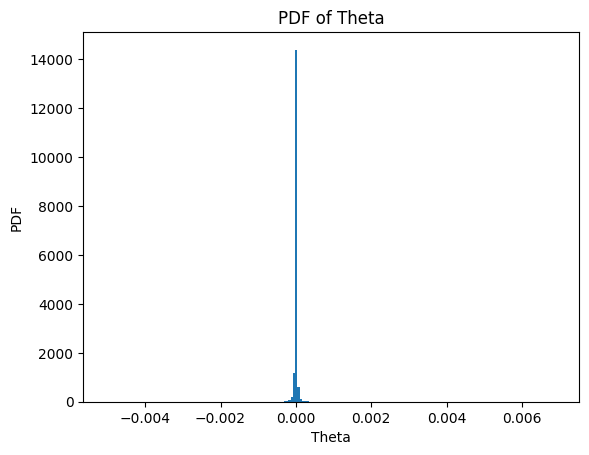

In [17]:
import matplotlib.pyplot as plt

plt.hist(ds_dx_hatx_G.values.flatten(), bins=200, density=True)
plt.xlabel("Theta")
plt.ylabel("PDF")
plt.title("PDF of Theta")
plt.show()

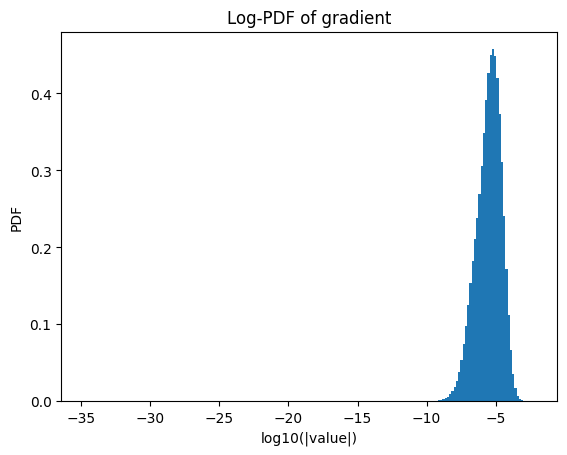

In [20]:
import numpy as np

vals = np.abs(ds_dx_hatx_G.values.ravel())
vals = vals[(vals > 0) & ~np.isnan(vals)]

logvals = np.log10(vals)

plt.hist(logvals, bins=200, density=True)
plt.xlabel("log10(|value|)")
plt.ylabel("PDF")
plt.title("Log-PDF of gradient")
plt.show()

(<Figure size 1080x540 with 2 Axes>,
 <GeoAxes: >,
 array([[-179.875, -179.625, -179.375, ...,  179.375,  179.625,  179.875],
        [-179.875, -179.625, -179.375, ...,  179.375,  179.625,  179.875],
        [-179.875, -179.625, -179.375, ...,  179.375,  179.625,  179.875],
        ...,
        [-179.875, -179.625, -179.375, ...,  179.375,  179.625,  179.875],
        [-179.875, -179.625, -179.375, ...,  179.375,  179.625,  179.875],
        [-179.875, -179.625, -179.375, ...,  179.375,  179.625,  179.875]],
       shape=(720, 1440)),
 array([[-89.875, -89.875, -89.875, ..., -89.875, -89.875, -89.875],
        [-89.625, -89.625, -89.625, ..., -89.625, -89.625, -89.625],
        [-89.375, -89.375, -89.375, ..., -89.375, -89.375, -89.375],
        ...,
        [ 89.375,  89.375,  89.375, ...,  89.375,  89.375,  89.375],
        [ 89.625,  89.625,  89.625, ...,  89.625,  89.625,  89.625],
        [ 89.875,  89.875,  89.875, ...,  89.875,  89.875,  89.875]],
       shape=(720, 1440)),
 ma

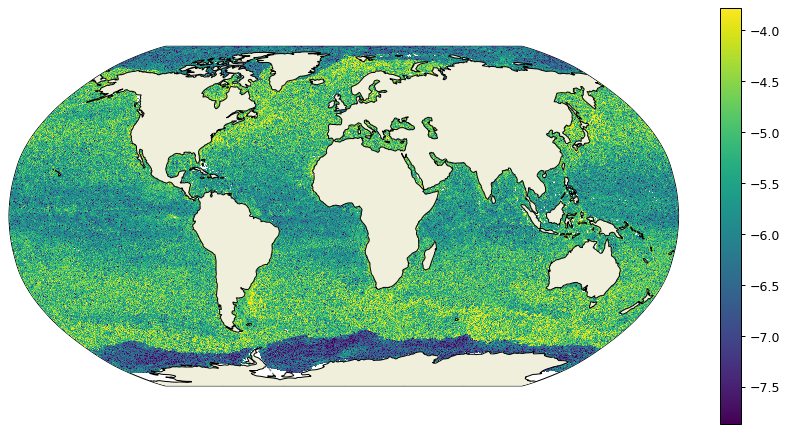

In [37]:
vals = np.abs(ds_dx_hatx_G)
vals = vals.where(vals > 0)

logvals = np.log10(vals)

vmin = float(logvals.quantile(0.01))
vmax = float(logvals.quantile(0.99))

print(vmin, vmax)

plt.figure(figsize=(12,6), dpi= 90)

ecco.plot_proj_to_latlon_grid(ds_merge.XC,
                              ds_merge.YC,
                              logvals,
                              cmap="viridis",
                              plot_type = 'pcolormesh',
                              dx=0.25,
                              dy=0.25,
                              projection_type = 'robin',
                              less_output = True,
                              show_colorbar=True,
                              cmin=vmin, cmax=vmax)

C:\Users\Jake Tallman\PycharmProjects\dbof-in-native-grid\src\plotting\llc_plotting.py:77: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


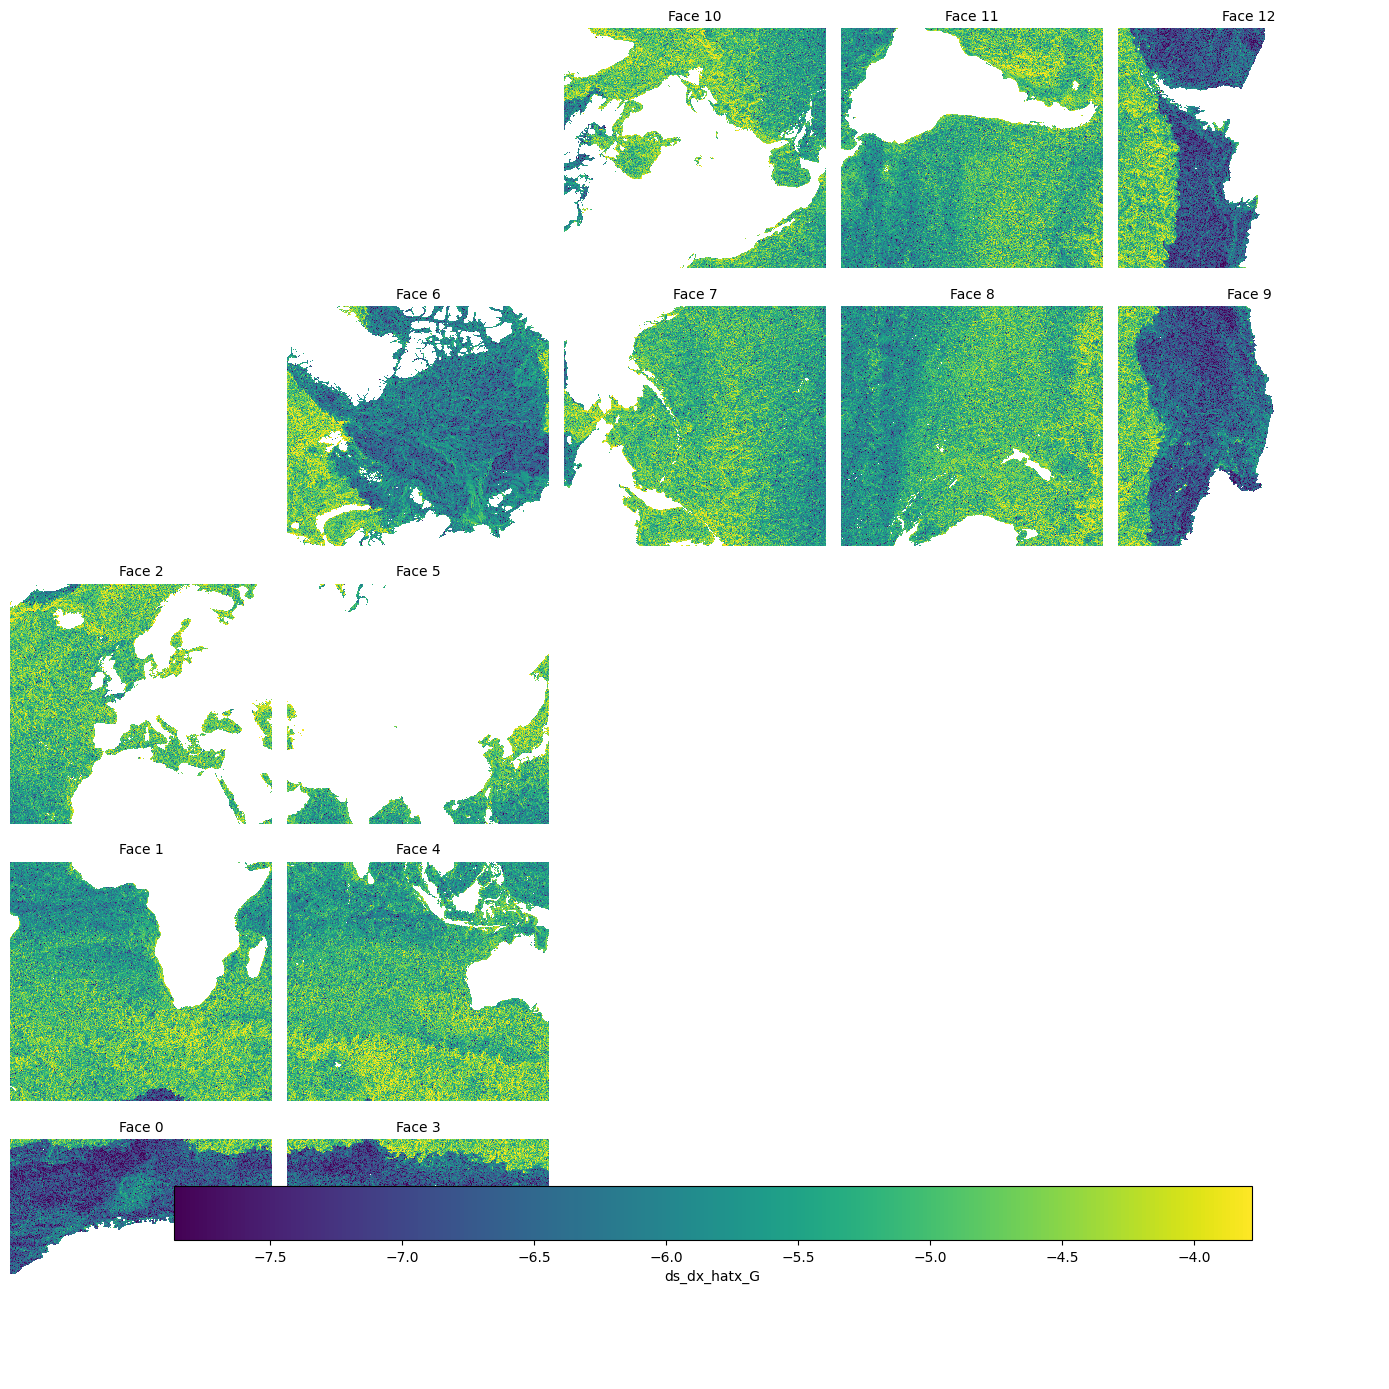

In [38]:
llc_plotting.plot_llc_faces_layout(logvals, "viridis", vmin=vmin, vmax=vmax)

C:\Users\Jake Tallman\PycharmProjects\dbof-in-native-grid\src\plotting\llc_plotting.py:77: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


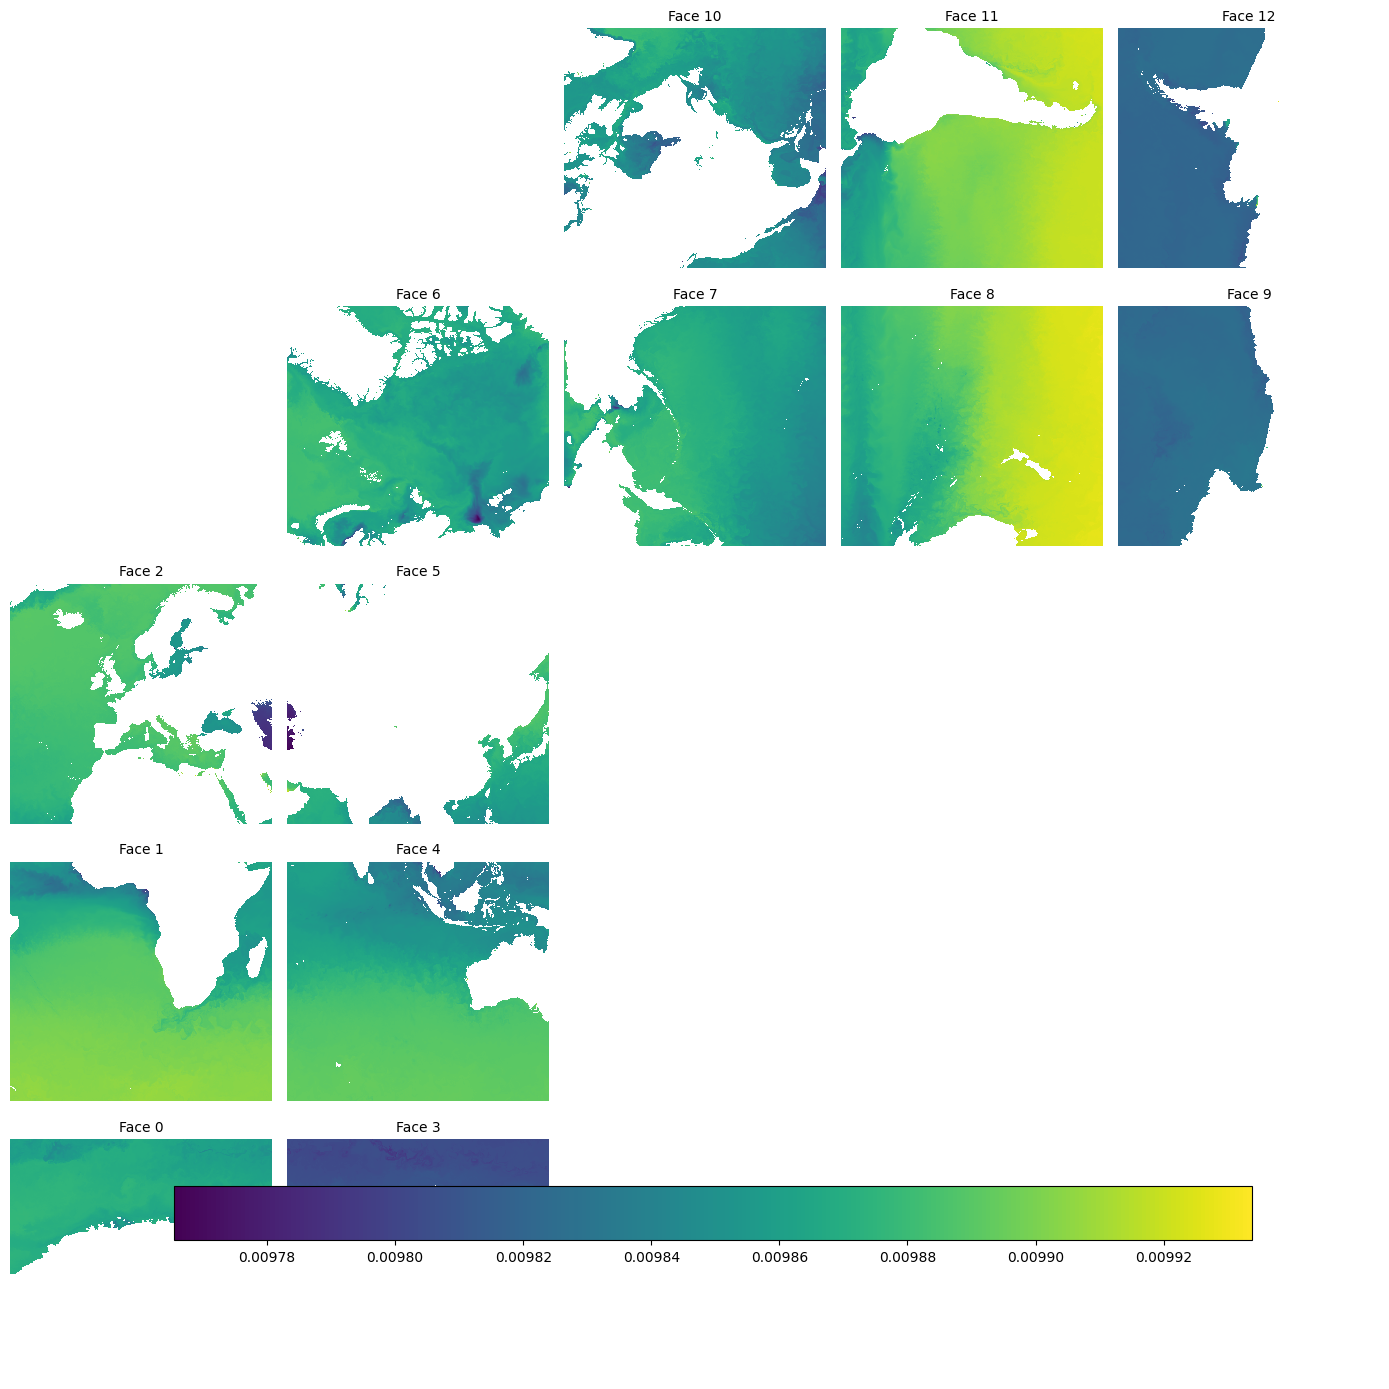

In [46]:
llc_plotting.plot_llc_faces_layout(buoyancy, "viridis")

Leftover plotting stuff :

In [30]:
# # plot theta
# llc_plotting.plot_llc_faces_layout(ds_merge.Theta)

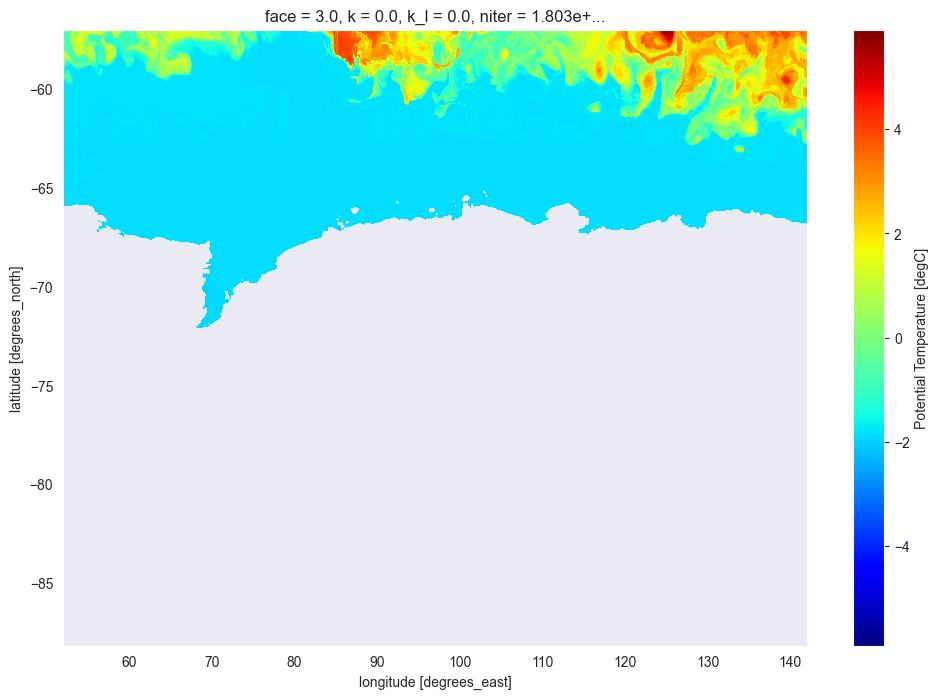

In [170]:
# #downsample plotting by real coordinates
# i_sub = slice(None, None, 40)
# j_sub = slice(None, None, 40)
#
# # Select theta for this face
# theta_face = ds_merge.Theta.isel(face=3)
#
# # Assign real coordinates
# theta_face = theta_face.assign_coords(x=ds_merge.XC.isel(face=3),
#                                       y=ds_merge.YC.isel(face=3))
#
# # Now xarray will use these for plotting
# theta_face.plot(x='x', y='y', cmap='jet', figsize=(12,8))

In [31]:
# import matplotlib.pyplot as plt
#
# face = 0
# plt.figure(figsize=(10, 8))
# plt.pcolormesh(ds_merge_sub.XC.isel(face=face),
#                ds_merge_sub.YC.isel(face=face),
#                ds_merge_sub.SN.isel(face=face),
#                cmap='jet', shading='auto')
# plt.title(f"SN for Face {face}")
# plt.xlabel("Longitude")
# plt.ylabel("Latitude")
# plt.show()

In [28]:
# face = 6
# var = "Theta"
#
# var_at_face = ds_merge[var][face]
#
# var_at_face

In [31]:
# # Confirm the location of the gradients in 'X' and 'Y' are at the 'u' and 'v' points, respectively.
# print(f'ds_dx_hatx_M: {ds_dx_hatx_M.shape, ds_dx_hatx_M.dims}')
# print(f'ds_dy_haty_M: {ds_dy_haty_M.shape, ds_dy_haty_M.dims}')

In [32]:
# cmap = plt.cm.viridis.copy()            # make a copy of your colormap
# cmap.set_bad(color='red')               # NaNs will appear red

In [32]:
# # plot dxc
# llc_plotting.plot_llc_faces_layout(ds_merge.dyC, cmocean.cm.diff)


In [21]:
#min_val = ds_dy_haty_M.min().compute().item()

In [22]:
#max_val = ds_dy_haty_M.max().compute().item()

In [106]:
# print(min_val)
# print(max_val)

-0.013558614999055862
0.014731420204043388


In [23]:
# plot_llc_faces_layout(ds_dy_haty_M, cmocean.cm.diff) # vmin=-3e-4, vmax=3e-4)
#
# # plot_a_face_by_var(ds_dy_haty_M, 6, cmap, vmin=-3e-6, vmax=3e-6)

C:\Users\Jake Tallman\PycharmProjects\dbof-in-native-grid\src\plotting\llc_plotting.py:77: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


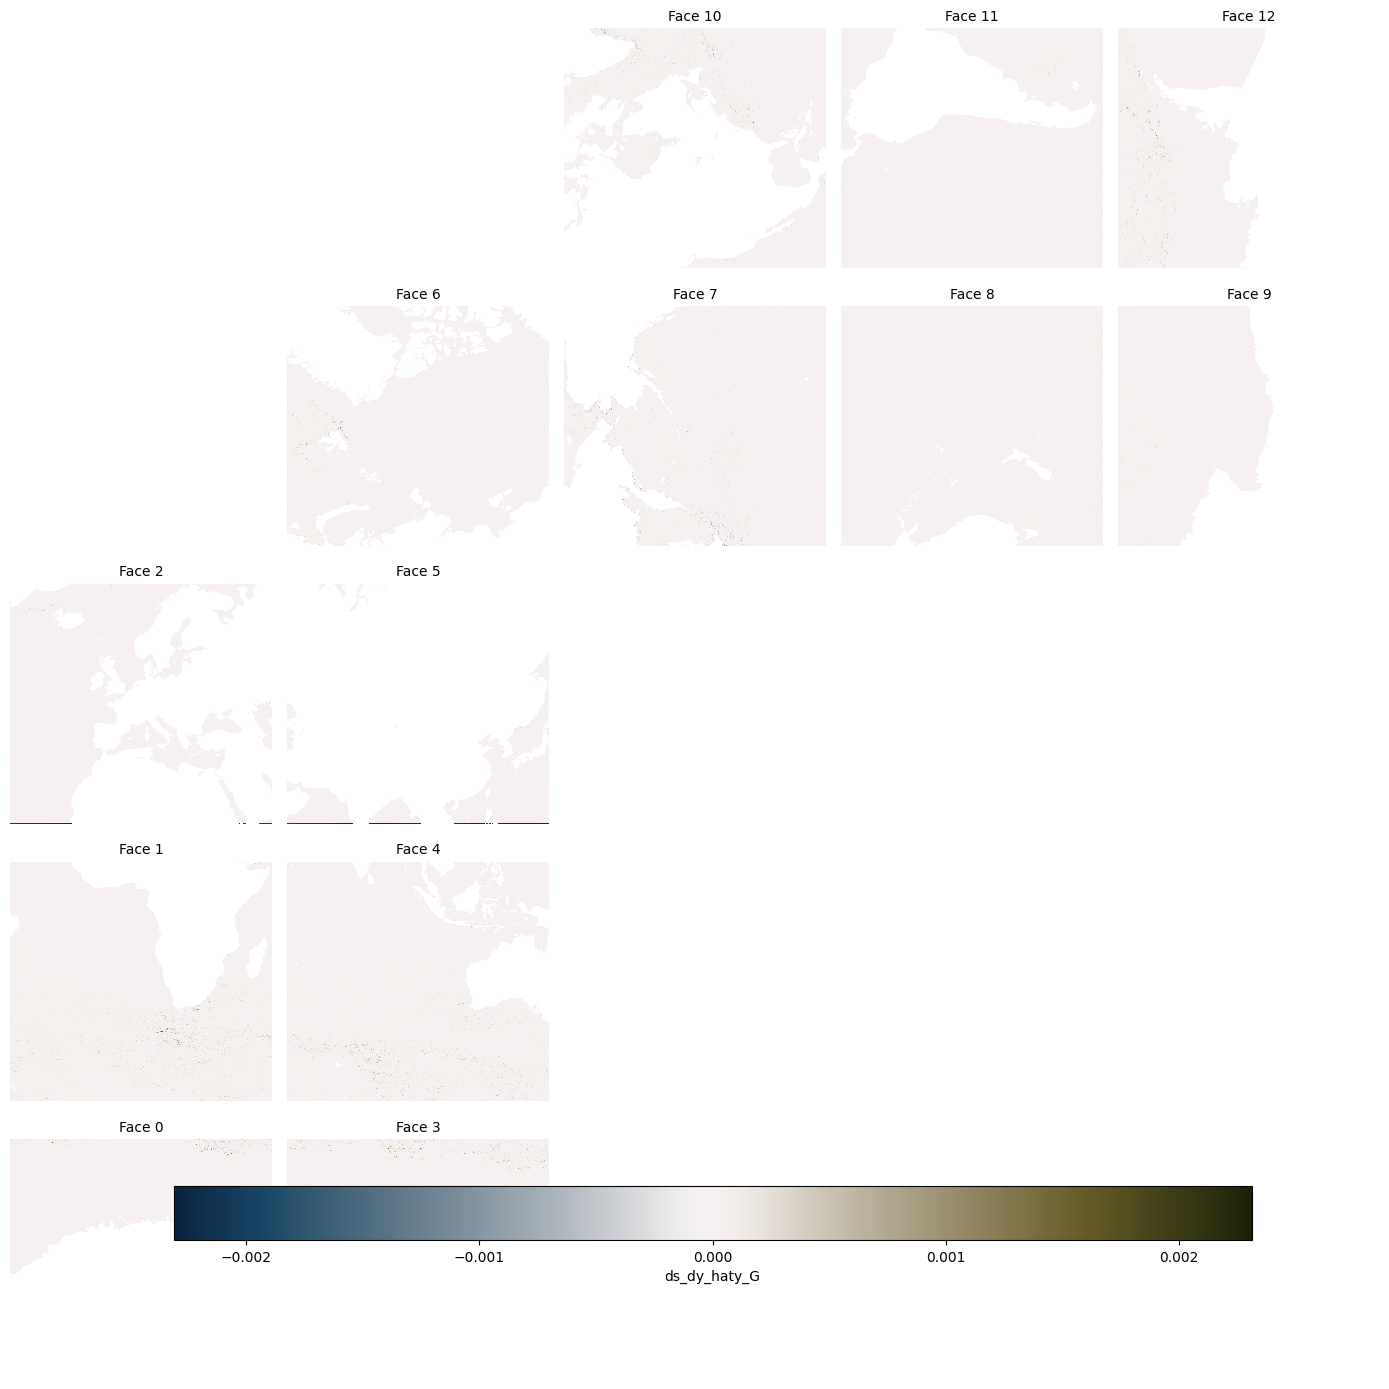

In [15]:
#Merid
llc_plotting.plot_llc_faces_layout(ds_dy_haty_G, cmocean.cm.diff)

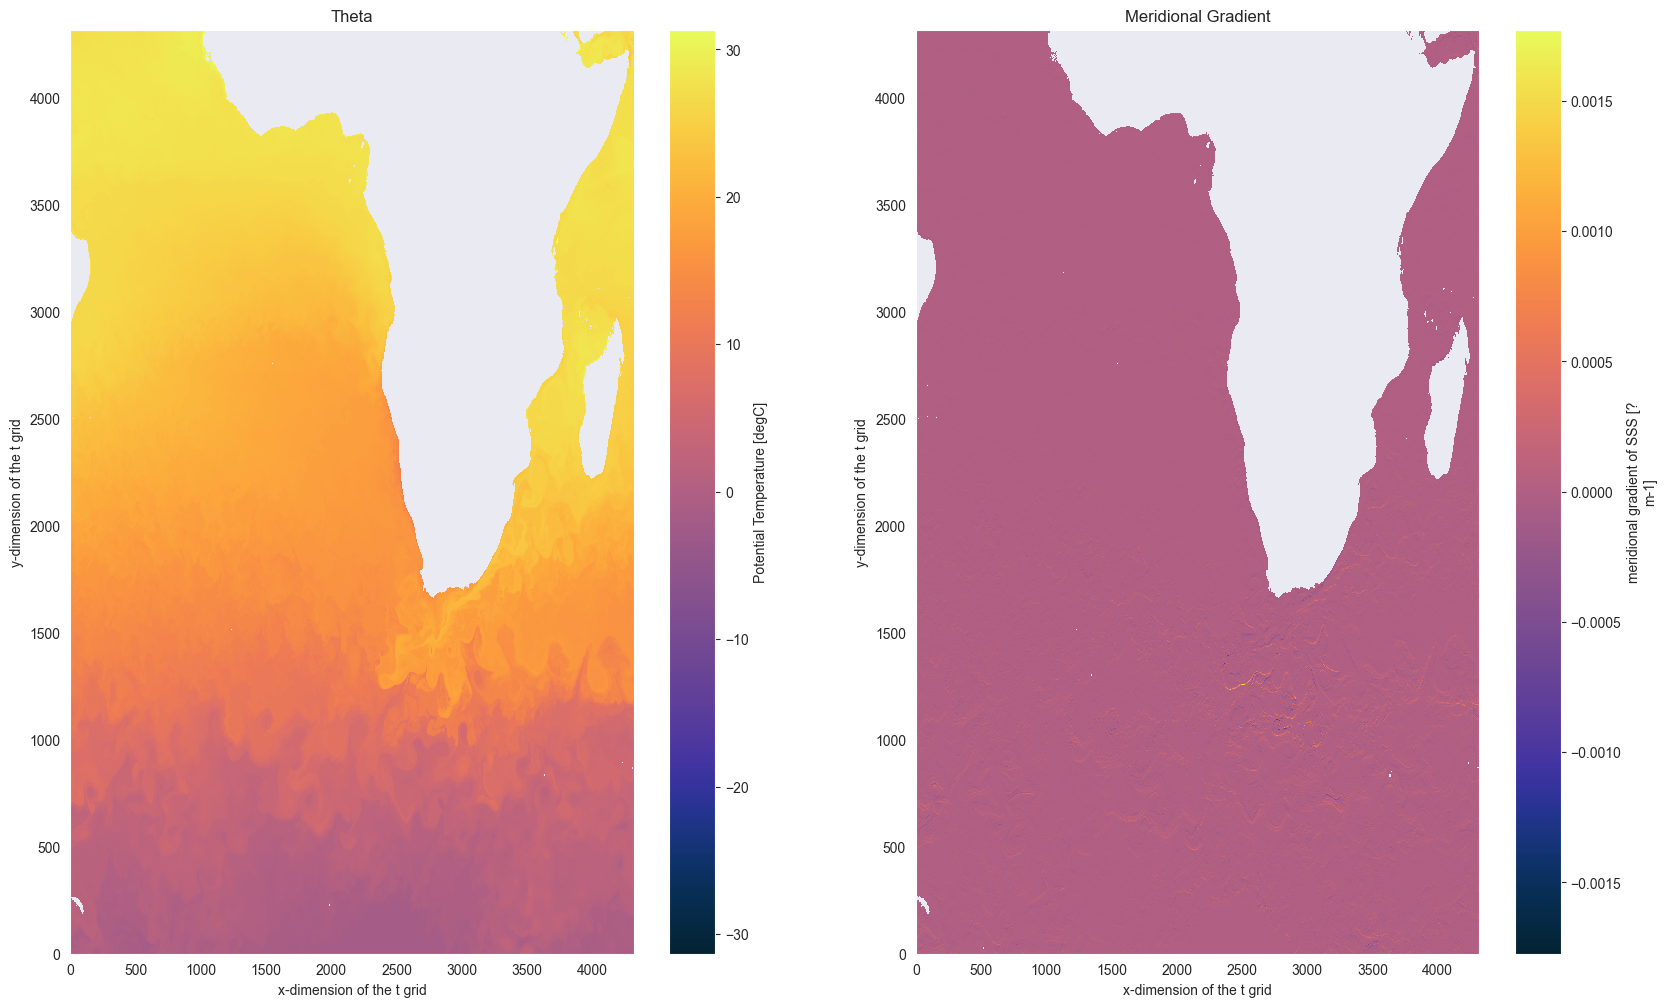

In [163]:
# theta and vertical grad
llc_plotting.plot_a_face_by_two_var(ds_merge.Theta, ds_dy_haty_G, "Theta", "Meridional Gradient", 1)

#vmin1=-1e-6, vmax1=1e-6)
# theta sea ice : -1.8 - 0

(<Figure size 1080x540 with 2 Axes>,
 <GeoAxes: >,
 array([[-179.875, -179.625, -179.375, ...,  179.375,  179.625,  179.875],
        [-179.875, -179.625, -179.375, ...,  179.375,  179.625,  179.875],
        [-179.875, -179.625, -179.375, ...,  179.375,  179.625,  179.875],
        ...,
        [-179.875, -179.625, -179.375, ...,  179.375,  179.625,  179.875],
        [-179.875, -179.625, -179.375, ...,  179.375,  179.625,  179.875],
        [-179.875, -179.625, -179.375, ...,  179.375,  179.625,  179.875]],
       shape=(720, 1440)),
 array([[-89.875, -89.875, -89.875, ..., -89.875, -89.875, -89.875],
        [-89.625, -89.625, -89.625, ..., -89.625, -89.625, -89.625],
        [-89.375, -89.375, -89.375, ..., -89.375, -89.375, -89.375],
        ...,
        [ 89.375,  89.375,  89.375, ...,  89.375,  89.375,  89.375],
        [ 89.625,  89.625,  89.625, ...,  89.625,  89.625,  89.625],
        [ 89.875,  89.875,  89.875, ...,  89.875,  89.875,  89.875]],
       shape=(720, 1440)),
 ma

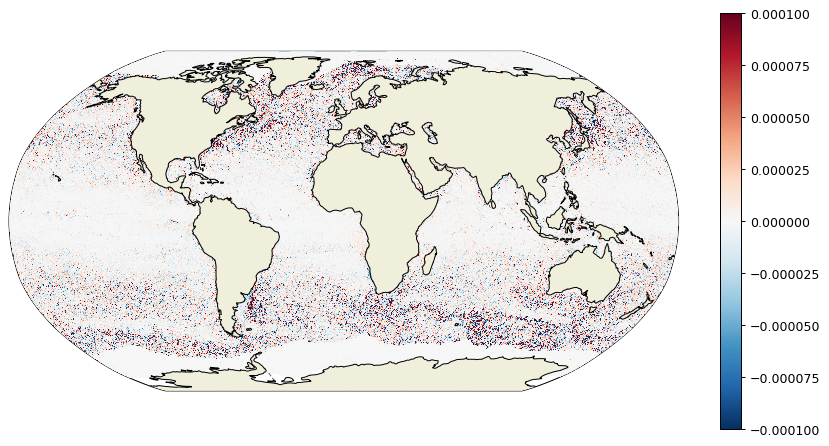

In [18]:


plt.figure(figsize=(12,6), dpi= 90)

tmp_plt = ds_dx_hatx_G

ecco.plot_proj_to_latlon_grid(ds_merge.XC,
                              ds_merge.YC,
                              tmp_plt,
                              cmap='RdBu_r',
                              plot_type = 'pcolormesh',
                              dx=0.25,
                              dy=0.25,
                              projection_type = 'robin',
                              less_output = True,
                              show_colorbar=True,
                              cmin=-1e-4, cmax=1e-4)

In [49]:
ds_dx_hatx_G

<xarray.DataArray 'ds_dx_hatx_G' (face: 13, j: 4320, i: 4320)> Size: 970MB
dask.array<sub, shape=(13, 4320, 4320), dtype=float32, chunksize=(1, 360, 360), chunktype=numpy.ndarray>
Coordinates:
  * face     (face) float64 104B 0.0 1.0 2.0 3.0 4.0 ... 8.0 9.0 10.0 11.0 12.0
  * j        (j) float64 35kB 0.0 1.0 2.0 3.0 ... 4.317e+03 4.318e+03 4.319e+03
  * i        (i) float64 35kB 0.0 1.0 2.0 3.0 ... 4.317e+03 4.318e+03 4.319e+03
    k        float64 8B 0.0
    k_l      float64 8B 0.0
    niter    float64 8B dask.array<chunksize=(), meta=np.ndarray>
    time     datetime64[ns] 8B 2011-11-01T04:00:00
Attributes:
    long_name:  zonal gradient of SSS
    units:      ? m-1

In [45]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs



sm = llcreader.llcmodel.faces_dataset_to_latlon(ds_merge, metric_vector_pairs=[]).Theta
XCm = llcreader.llcmodel.faces_dataset_to_latlon(ds_merge.XC, metric_vector_pairs=[])
YCm = llcreader.llcmodel.faces_dataset_to_latlon(ds_merge.YC, metric_vector_pairs=[])


# the model grid is in PlateCarree (regular lon/lat)
data_crs = ccrs.PlateCarree()

fig = plt.figure(figsize=(10, 6))

ax = plt.axes(projection=ccrs.Mercator())
ax.coastlines()

# plotting your model data at the correct lon/lat locations
pcm = ax.pcolormesh(
    XCm, YCm, sm,
    transform=data_crs,
    shading='auto'
)

plt.colorbar(pcm, ax=ax, label='Theta')
plt.show()

C:\Users\Jake Tallman\PycharmProjects\dbof-in-native-grid\.venv\Lib\site-packages\xmitgcm\llcreader\llcmodel.py:322: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  data = np.arange(ifac * coords.dims[vname])
C:\Users\Jake Tallman\PycharmProjects\dbof-in-native-grid\.venv\Lib\site-packages\xmitgcm\llcreader\llcmodel.py:324: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  data = np.arange(jfac * coords.dims[vname])


AttributeError: 'NoneType' object has no attribute 'set_coords'

In [43]:
s.shape

(13, 4320, 4320)

(<Figure size 640x480 with 2 Axes>,
 <GeoAxes: >,
 array([[-179.75, -179.25, -178.75, ...,  178.75,  179.25,  179.75],
        [-179.75, -179.25, -178.75, ...,  178.75,  179.25,  179.75],
        [-179.75, -179.25, -178.75, ...,  178.75,  179.25,  179.75],
        ...,
        [-179.75, -179.25, -178.75, ...,  178.75,  179.25,  179.75],
        [-179.75, -179.25, -178.75, ...,  178.75,  179.25,  179.75],
        [-179.75, -179.25, -178.75, ...,  178.75,  179.25,  179.75]],
       shape=(360, 720)),
 array([[-89.75, -89.75, -89.75, ..., -89.75, -89.75, -89.75],
        [-89.25, -89.25, -89.25, ..., -89.25, -89.25, -89.25],
        [-88.75, -88.75, -88.75, ..., -88.75, -88.75, -88.75],
        ...,
        [ 88.75,  88.75,  88.75, ...,  88.75,  88.75,  88.75],
        [ 89.25,  89.25,  89.25, ...,  89.25,  89.25,  89.25],
        [ 89.75,  89.75,  89.75, ...,  89.75,  89.75,  89.75]],
       shape=(360, 720)),
 masked_array(
   data=[[           nan,            nan,            nan, ...,


C:\Users\Jake Tallman\PycharmProjects\dbof-in-native-grid\.venv\Lib\site-packages\cartopy\io\__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


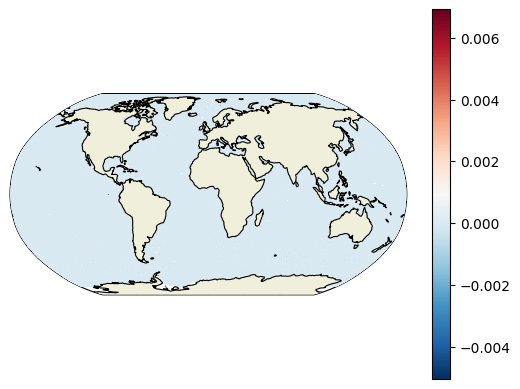

In [40]:
import ecco_v4_py as ecco

ecco.plot_proj_to_latlon_grid(ds_merge.XC, ds_merge.YC, ds_dx_hatx_G,
                               dx=.5, dy=.5, show_colorbar=True, user_lon_0=0)

In [18]:
#plot_a_face_by_var(ds_dy_haty_G, 1)
# todo make this a plot function


# plot in lat lon
lat_lon_merid_grad = ds_dy_haty_G.isel(face=6)

# Assign real coordinates
theta_face_latlon = lat_lon_merid_grad.assign_coords(x=ds_dy_haty_G.XC.isel(face=6),
                                      y=ds_dy_haty_G.YC.isel(face=6))

# Now xarray will use these for plotting
theta_face_latlon.plot(x='x', y='y', cmap=cmocean.cm.thermal, figsize=(12,8))

AttributeError: 'DataArray' object has no attribute 'XC'

In [161]:
print(ds_dy_haty_G[0].min().compute().item())

-0.0006007268093526363
